In [18]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import os
from sqlalchemy import create_engine
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [19]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [20]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 10001
Time taken to count the number of rows : 0:00:00.008003


In [21]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:00:00.354658


In [22]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1
1,"""<handler> scriptProcessor could not be found ...",<p><br>\r\nI have a configuration problem with...,php iis fastcgi,1
2,"""Ads not by this site"" displayed by ads inject...",<p>I'm having ads injected into random pages i...,windows spyware adware,1
3,"""An item with the same key has already been ad...",<p>I'm trying to replace an existing serialize...,c# dictionary protocol-buffers protobuf-net,1
4,"""Back"" command for org-mode",<p>When I type <code>C-c C-v</code> to see the...,emacs org-mode,1


In [23]:
df_no_dup.cnt_dup.value_counts()

1    9995
2       3
Name: cnt_dup, dtype: int64

In [24]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.031252


,Title,Body,Tags,cnt_dup,tag_count
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1,2
1,"""<handler> scriptProcessor could not be found ...",<p><br>\r\nI have a configuration problem with...,php iis fastcgi,1,3
2,"""Ads not by this site"" displayed by ads inject...",<p>I'm having ads injected into random pages i...,windows spyware adware,1,3
3,"""An item with the same key has already been ad...",<p>I'm trying to replace an existing serialize...,c# dictionary protocol-buffers protobuf-net,1,4
4,"""Back"" command for org-mode",<p>When I type <code>C-c C-v</code> to see the...,emacs org-mode,1,2


In [25]:
df_no_dup.tag_count.value_counts()

3    2919
2    2612
4    1969
1    1297
5    1201
Name: tag_count, dtype: int64

In [26]:
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [27]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()
    tag_data.drop(tag_data.index[0], inplace=True)
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:00.109270


In [28]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])


In [29]:
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.htaccess', '.net', '.net-2.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-assembly', '.net-framework', '.net4.0', '.refresh']


In [30]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [31]:
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.htaccess,40
1,.net,302
2,.net-2.0,6
3,.net-3.5,7
4,.net-4.0,10


In [32]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

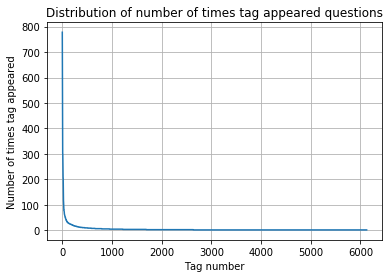

In [33]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()


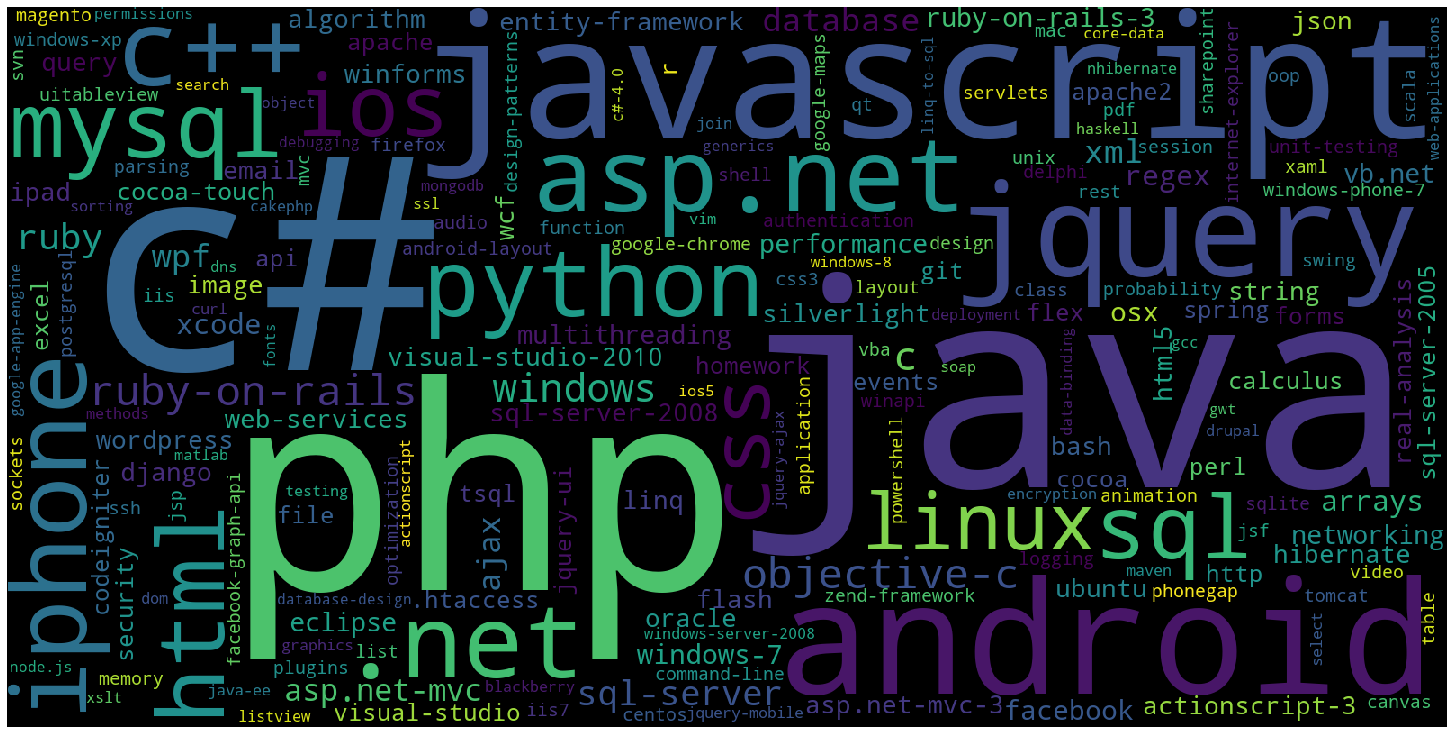

Time taken to run this cell : 0:00:15.306756


In [34]:
start = datetime.now()
tup = dict(result.items())
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

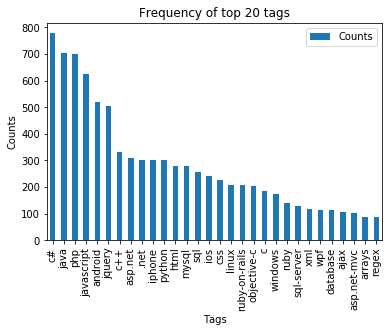

In [35]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()